# **TRABAJO INTEGRADOR PROCESAMIENTO DEL LENGUAJE NATURAL**

Grupo 4

# **Preparación del dataset**

En este bloque se prepara el conjunto de datos para ser utilizado con modelos de Hugging Face. Se combinan columnas de texto, se convierten etiquetas a números y se dividen los datos para entrenamiento y prueba. Finalmente, se transforma el DataFrame a un objeto Dataset compatible con Hugging Face.



In [2]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder


c:\Users\ezevi\Desktop\estudio\UP\2025-1\PLN\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Cargar el dataset
df = pd.read_csv('dataset_balanceado_7000_por_clase.csv')

# Crear columna 'message' combinando subject + body
df['message'] = df['subject'].fillna('') + ' ' + df['body'].fillna('')

# Convertir etiquetas a números
le = LabelEncoder()
df['label'] = le.fit_transform(df['type']) 

df_hf = df[['message', 'label']]  

# Separar train/test (ejemplo simple, podés mejorarlo)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_hf, test_size=0.2, random_state=42, stratify=df_hf['label'])

# Convertir a HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


# **Tokenización con BERT**
En este bloque se convierte el texto plano en tokens que BERT puede procesar. Se utiliza el tokenizer preentrenado de BERT (bert-base-uncased) y se aplica a todo el dataset de entrenamiento y test con truncamiento automático para que no exceda la longitud máxima permitida.

In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_fn(example):
    return tokenizer(example["message"], truncation=True)

train_dataset = train_dataset.map(tokenize_fn, batched=True)
test_dataset = test_dataset.map(tokenize_fn, batched=True)


Map: 100%|██████████| 5600/5600 [00:04<00:00, 1328.97 examples/s]


# **Inicialización del modelo BERT para clasificación**
En este bloque se carga un modelo BERT preentrenado y se adapta para una tarea de clasificación de texto multiclase (con 4 clases). Esto permite usar BERT como base y ajustar sus pesos para tu problema específico.

In [5]:
num_labels = 4
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **Configuración de los argumentos de entrenamiento**
Este bloque configura todos los parámetros necesarios para entrenar el modelo BERT, como la tasa de aprendizaje, tamaño de lote, número de épocas, y dónde guardar los resultados. Esto se usa luego al instanciar el Trainer.

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",              #Carpeta donde guardamos todo
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",                    
    save_strategy="epoch"               #Guarda al final de cada época
)

# **Configuración del Trainer de Hugging Face**
Se desactiva la integración con wandb, se crea un data_collator para rellenar dinámicamente los lotes, y se construye el Trainer, el componente principal que se encargará de entrenar y evaluar el modelo.

In [9]:
# Desactivar wandb para evitar login automático
import os
os.environ["WANDB_DISABLED"] = "true"
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# Entrenador
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)


C:\Users\ezevi\AppData\Local\Temp\ipykernel_16588\659746233.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [10]:
# Entrenamiento
trainer.train()

Step,Training Loss
500,0.524400
1000,0.350800
1500,0.323900
2000,0.311100
2500,0.287100
3000,0.233800
3500,0.201600
4000,0.204600
4500,0.175900
5000,0.184200


TrainOutput(global_step=11200, training_loss=0.1590273998251983, metrics={'train_runtime': 1486.9797, 'train_samples_per_second': 60.256, 'train_steps_per_second': 7.532, 'total_flos': 5397787339196928.0, 'train_loss': 0.1590273998251983, 'epoch': 4.0})

# **Evaluación del modelo y visualización de resultados**
Una vez entrenado el modelo, se evalúa su rendimiento en el conjunto de prueba. Se imprimen métricas estándar (precision, recall, F1-score) para cada clase y se visualiza la matriz de confusión para detectar errores frecuentes en las predicciones.

              precision    recall  f1-score   support

      Change       1.00      1.00      1.00      1400
    Incident       0.94      0.93      0.93      1400
     Problem       0.93      0.94      0.94      1400
     Request       1.00      1.00      1.00      1400

    accuracy                           0.97      5600
   macro avg       0.97      0.97      0.97      5600
weighted avg       0.97      0.97      0.97      5600



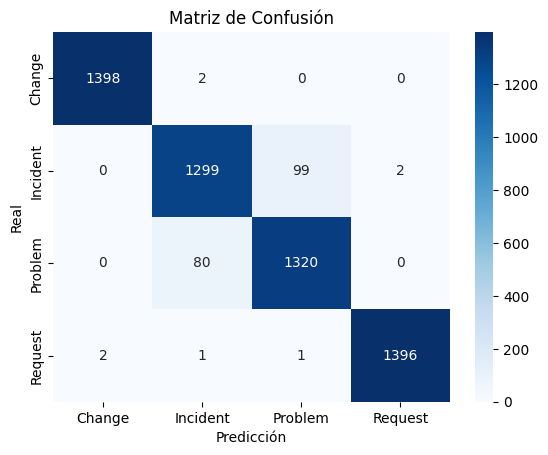

In [12]:
# Evaluación manual
preds = trainer.predict(test_dataset)

# Obtener predicciones como clase
pred_labels = np.argmax(preds.predictions, axis=1)

# Ver métricas
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Reporte completo por clase
print(classification_report(test_df['label'], pred_labels, target_names=le.classes_))

# Matriz de confusión
cm = confusion_matrix(test_df['label'], pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# **Guardado del modelo y tokenizer fine-tuneado**
Una vez entrenado y evaluado, el modelo BERT ajustado se guarda junto con su tokenizer en una carpeta. Esto permite cargar el modelo directamente en futuras ejecuciones o para desplegarlo en producción.

In [13]:
# Guardar modelo y tokenizer
model.save_pretrained("modelo_finetune_bert")
tokenizer.save_pretrained("modelo_finetune_bert")

('modelo_finetune_bert\\tokenizer_config.json',
 'modelo_finetune_bert\\special_tokens_map.json',
 'modelo_finetune_bert\\vocab.txt',
 'modelo_finetune_bert\\added_tokens.json')

# **Interfaz interactiva para clasificar mensajes con BERT**
Se define una interfaz de usuario simple con ipywidgets, donde se puede ingresar un mensaje de texto y obtener la clase predicha (como "Incident", "Request", etc.) utilizando el modelo entrenado. Es útil para probar el modelo en tiempo real sin necesidad de escribir código manualmente.

In [ ]:
# === Interfaz interactiva para clasificar mensajes de soporte con BERT fine-tuneado ===

import torch
from transformers import BertTokenizer, BertForSequenceClassification
import ipywidgets as widgets
from IPython.display import display

# Cargar tokenizer y modelo fine-tuneado
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('modelo_finetune_bert')
bert_model.eval()

# Diccionario de clases
id2label = {0: 'Change', 1: 'Incident', 2: 'Problem', 3: 'Request'}  

# Función para clasificar mensaje con modelo fine-tuneado
def clasificar_mensaje_bert(texto):
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(**inputs)
        logits = outputs.logits
        prediccion = torch.argmax(logits, dim=1).item()
    return id2label[prediccion]

# Crear interfaz con widgets
input_texto = widgets.Textarea(
    value='',
    placeholder='Escribí el mensaje de soporte acá...',
    description='Mensaje:',
    layout=widgets.Layout(width='100%', height='100px')
)

boton = widgets.Button(description='Clasificar')
salida = widgets.Output()

def al_clickear_boton(b):
    with salida:
        salida.clear_output()
        texto = input_texto.value
        if texto.strip() == "":
            print("Por favor ingresá un mensaje.")
        else:
            resultado = clasificar_mensaje_bert(texto)
            print(f" Predicción: {resultado}")

boton.on_click(al_clickear_boton)

# Mostrar interfaz
display(input_texto, boton, salida)


Textarea(value='', description='Mensaje:', layout=Layout(height='100px', width='100%'), placeholder='Escribí e…

Button(description='Clasificar', style=ButtonStyle())

Output()